After splitting the data, we perform stratified sampling to ensure that the target variable's distribution is well-represented across both training and testing datasets. Post-split, we apply the Box-Cox transformation to the target variable to normalize its distribution, which helps improve the performance of the regression model. We then train a XGBRegressor on the transformed target variable. Once predictions are made, we apply the inverse Box-Cox transformation to convert the predictions back to the original scale. 

In [1]:
pip install xgboost

  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl (190.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install shap

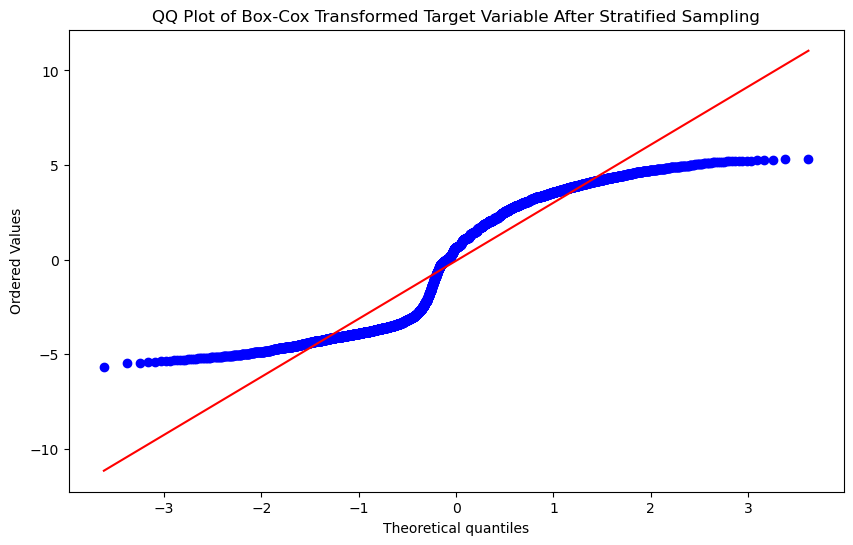

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import numpy as np
from xgboost import XGBRegressor
from scipy import stats


# Load the dataset
file_path = 'Updated_New_cleaned_dataset.csv'
data = pd.read_csv(file_path)

# Remove all columns related to time in seconds, minutes, and hours
columns_to_remove = ['time_diff_sec', 'time_diff_min', 'time_diff_hours']
data_cleaned = data.drop(columns=columns_to_remove)

# Define the target variable
target = 'time_diff_days'
X = data_cleaned.drop(columns=[target])
y = data_cleaned[target]

# Drop all object type columns and specified columns
columns_to_drop = [
    'user_id', 'order_id', 'submit_datetime', 'skuid', 'profile_created_time',
    'profile_created_time_sec', 'order_sumitted', 'COUNTRY',
    'COUNTRY_GROUPED_DE', 'COUNTRY_GROUPED_FR', 'COUNTRY_GROUPED_IN',
    'COUNTRY_GROUPED_Others', 'COUNTRY_GROUPED_US'
]

X = X.drop(columns=columns_to_drop)

# Create bins using pd.qcut for stratified sampling
num_bins = int(np.floor(1 + np.log2(len(y))))
y_binned = pd.qcut(y, q=num_bins, labels=False)

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Apply Box-Cox transformation to the target variable after stratified splitting
pt = PowerTransformer(method='box-cox', standardize=False)
y_train_boxcox = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_boxcox = pt.transform(y_test.values.reshape(-1, 1)).flatten()

# Plot the QQ plot for the transformed target variable
plt.figure(figsize=(10, 6))
stats.probplot(y_train_boxcox, dist="norm", plot=plt)
plt.title("QQ Plot of Box-Cox Transformed Target Variable After Stratified Sampling")
plt.show()


Evaluating with MinMaxScaler


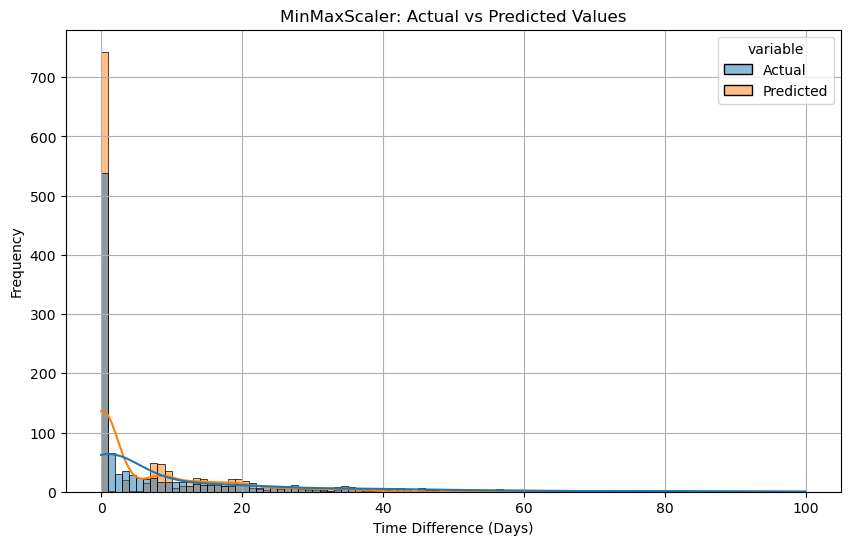

Evaluating with StandardScaler


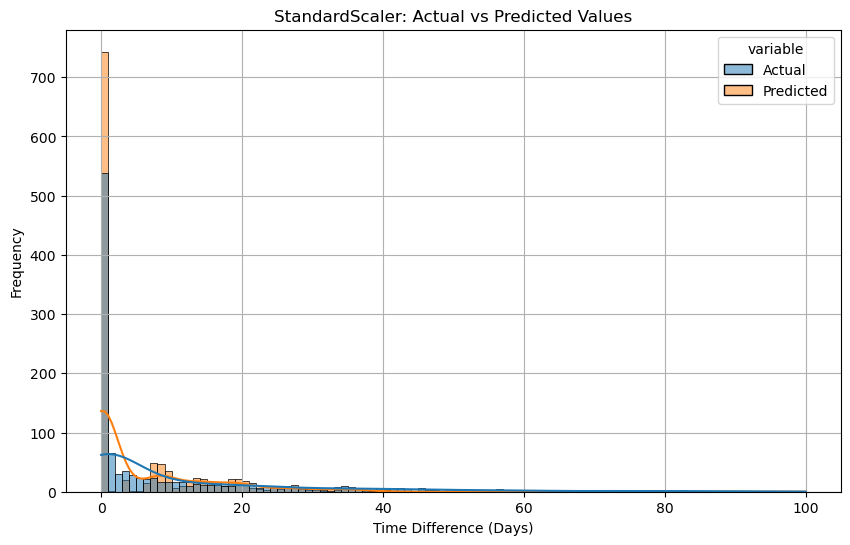

Evaluating with RobustScaler


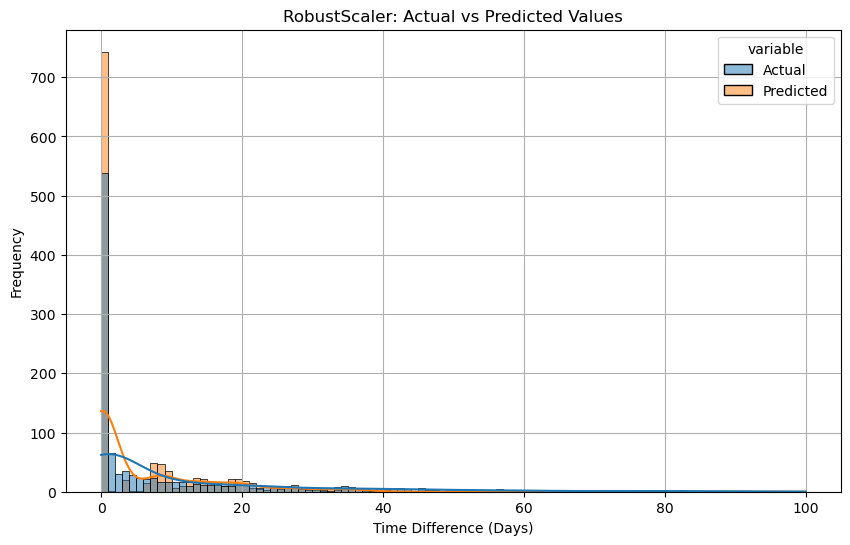

,Scaler,Best Params,MSE,RMSE,MAE,R2 Score,CV_MSE,CV_RMSE,CV_MAE,CV_R2,FeatureImportances,BestModel
0,MinMaxScaler,{'model__colsample_bytree': 0.8333333333333333...,252.302238,15.884025,7.95123,0.25523,5.614098,2.369288,1.912546,0.463814,"[0.017256754, 0.010296858, 0.06466923, 0.02149...","(MinMaxScaler(), XGBRegressor(base_score=None,..."
1,StandardScaler,{'model__colsample_bytree': 0.8333333333333333...,252.302238,15.884025,7.95123,0.25523,5.614098,2.369288,1.912546,0.463814,"[0.017256754, 0.010296858, 0.06466923, 0.02149...","(StandardScaler(), XGBRegressor(base_score=Non..."
2,RobustScaler,{'model__colsample_bytree': 0.8333333333333333...,252.302238,15.884025,7.95123,0.25523,5.614098,2.369288,1.912546,0.463814,"[0.017256754, 0.010296858, 0.06466923, 0.02149...","(RobustScaler(), XGBRegressor(base_score=None,..."


In [4]:
from xgboost import XGBRegressor

# Define scalers to compare
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': sp_randint(100, 1000),
    'model__learning_rate': np.linspace(0.01, 0.3, num=30),
    'model__max_depth': sp_randint(3, 10),
    'model__min_child_weight': sp_randint(1, 10),
    'model__subsample': np.linspace(0.5, 1.0, num=10),
    'model__colsample_bytree': np.linspace(0.5, 1.0, num=10),
    'model__gamma': np.linspace(0, 5, num=20)
}

# Initialize results dictionary
results = []

# Loop through each scaler
for scaler_name, scaler in scalers.items():
    print(f"Evaluating with {scaler_name}")
    
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
    ])
    
    # Initialize RandomizedSearchCV with verbose output
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, 
        n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train_boxcox)
    
    # Get the best model
    best_model = random_search.best_estimator_
    
    # Predict on the test set
    y_pred_boxcox = best_model.predict(X_test)
    
    # Inverse Box-Cox transformation to convert predictions back to the original scale
    y_pred_original_scale = pt.inverse_transform(y_pred_boxcox.reshape(-1, 1)).flatten()
    y_test_original = pt.inverse_transform(y_test_boxcox.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_original, y_pred_original_scale)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original_scale)
    r2 = r2_score(y_test_original, y_pred_original_scale)
    
    # Perform cross-validation on the training set
    cv_mse = -cross_val_score(best_model, X_train, y_train_boxcox, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(cv_mse)
    cv_mae = -cross_val_score(best_model, X_train, y_train_boxcox, cv=5, scoring='neg_mean_absolute_error')
    cv_r2 = cross_val_score(best_model, X_train, y_train_boxcox, cv=5, scoring='r2')
    
    # Store the results
    results.append({
        'Scaler': scaler_name,
        'Best Params': random_search.best_params_,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2,
        'CV_MSE': np.mean(cv_mse),
        'CV_RMSE': np.mean(cv_rmse),
        'CV_MAE': np.mean(cv_mae),
        'CV_R2': np.mean(cv_r2),
        'FeatureImportances': best_model.named_steps['model'].feature_importances_,
        'BestModel': best_model
    })

    # Create DataFrame with actual and predicted values
    results_df_xgb = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original_scale})

    # Plot histogram of actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df_xgb.melt(), bins=100, x='value', hue='variable', kde=True)
    plt.title(f'{scaler_name}: Actual vs Predicted Values')
    plt.xlabel('Time Difference (Days)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display the results
results_df


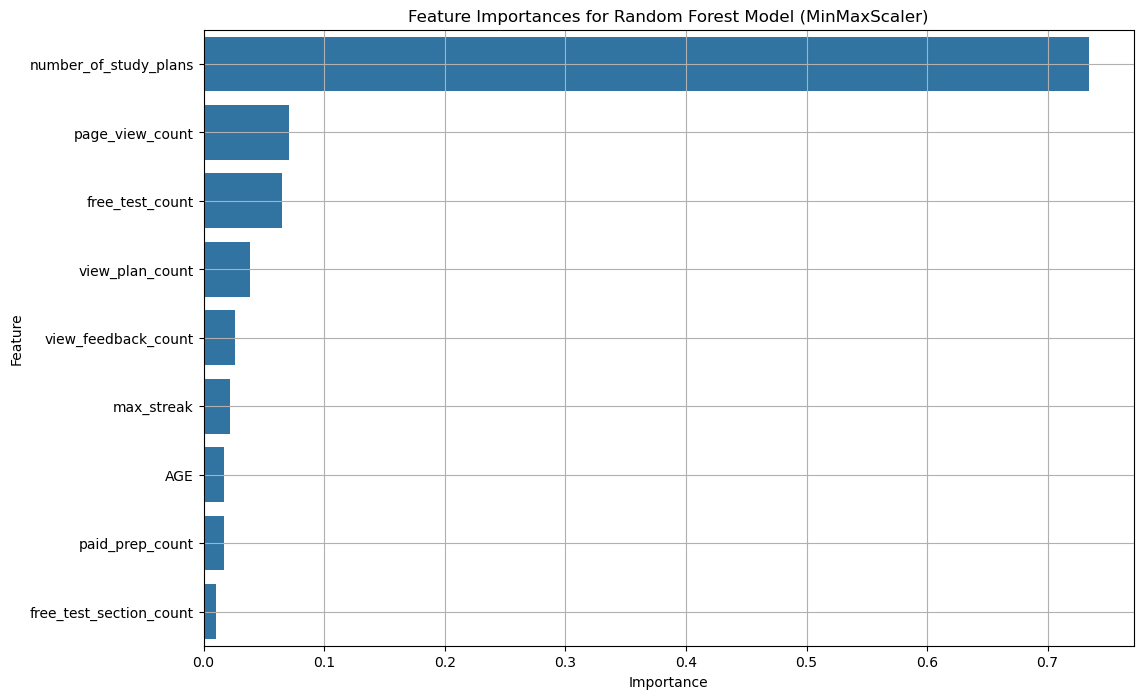

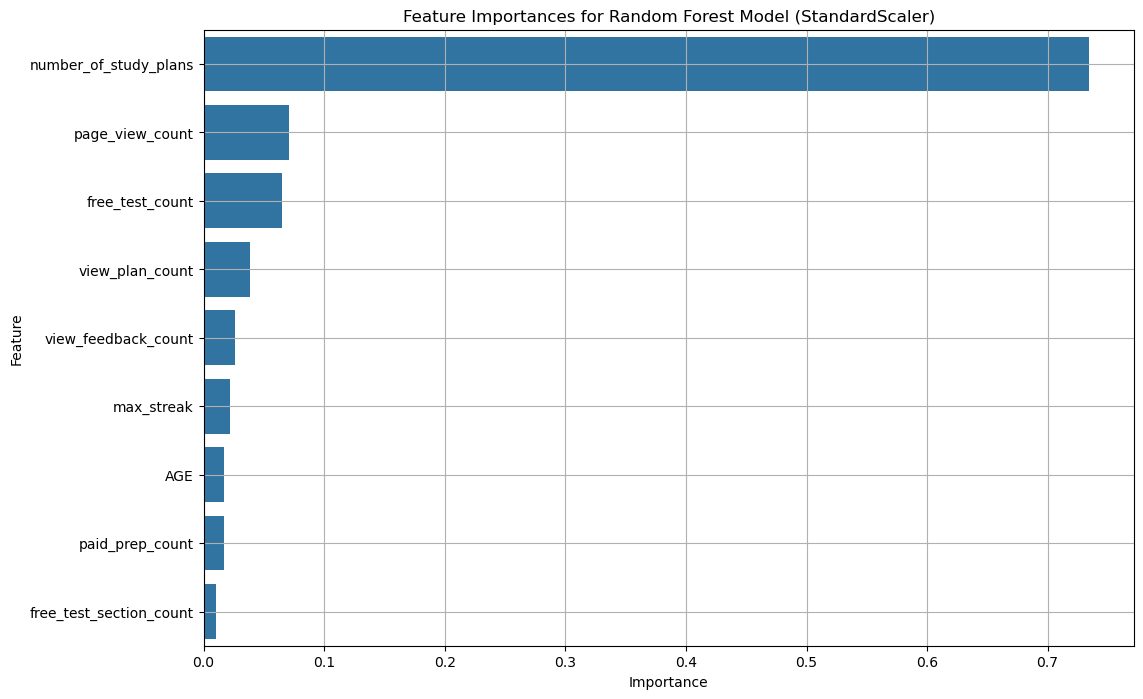

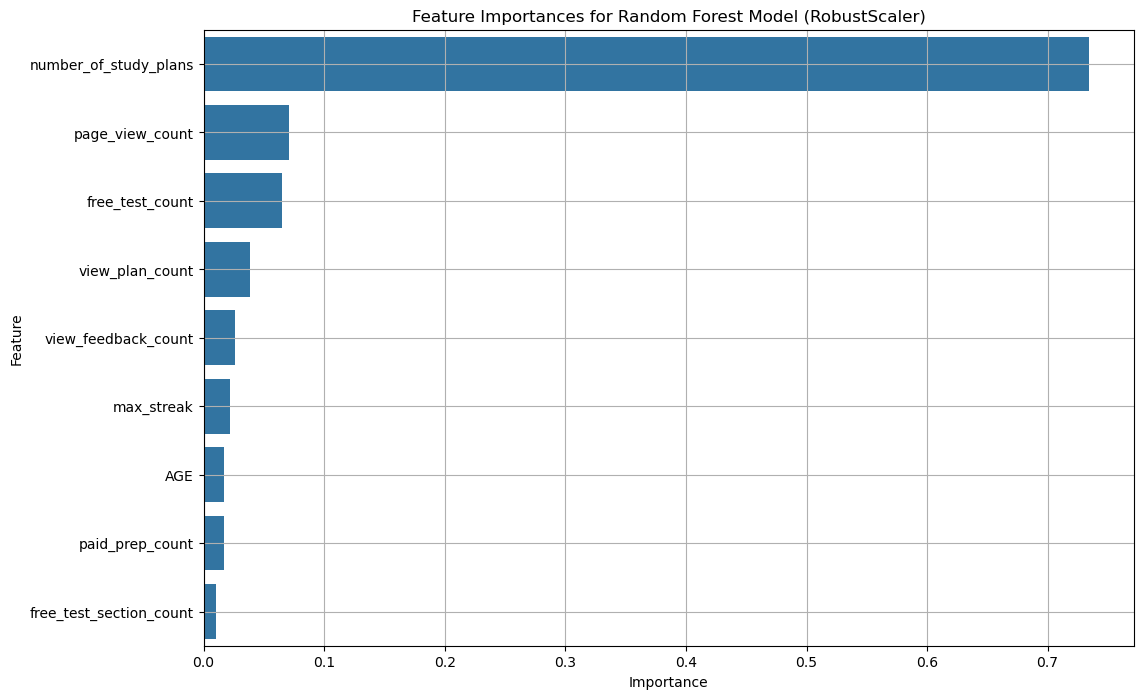

In [5]:
# Feature importance analysis
features = X.columns

for result in results:
    scaler_name = result['Scaler']
    feature_importances = result['FeatureImportances']
    
    # Create a DataFrame for feature importances
    feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    
    # Sort the DataFrame by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title(f'Feature Importances for Random Forest Model ({scaler_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid()
    plt.show()

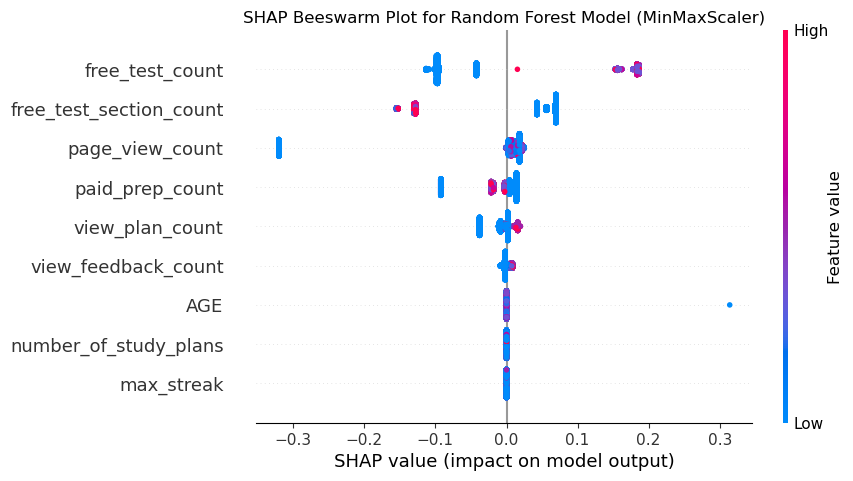

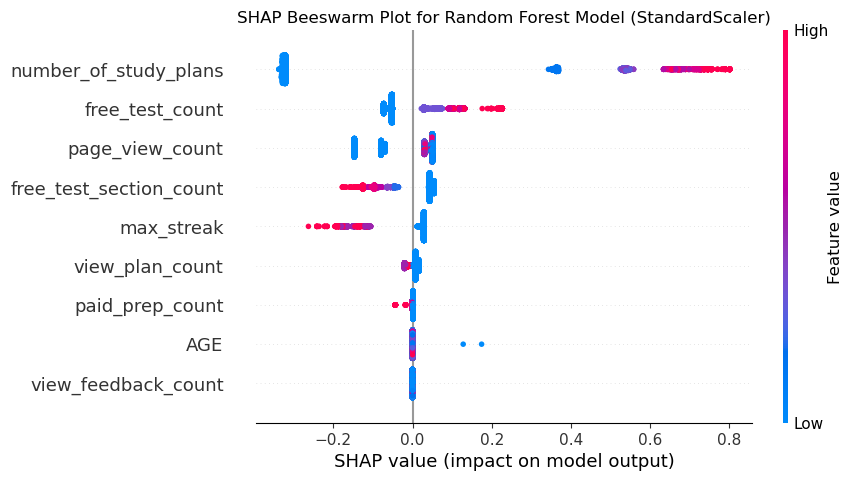

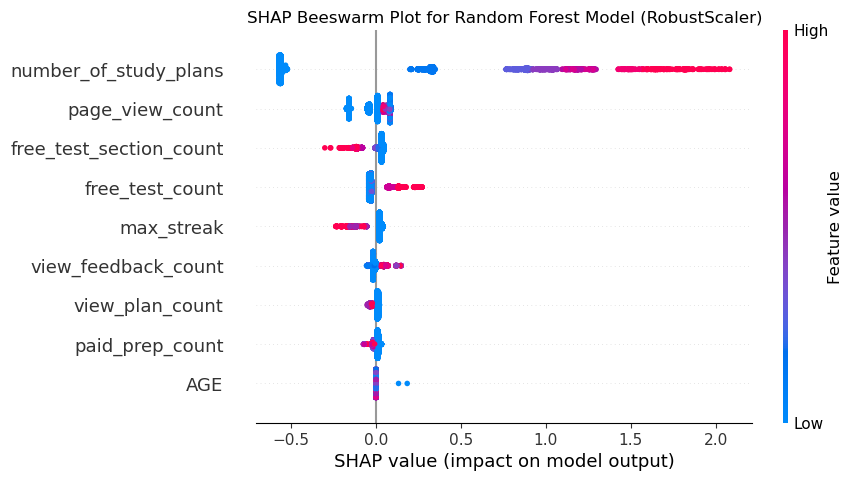

In [7]:
import shap

# SHAP beeswarm plot generation
for result in results:
    scaler_name = result['Scaler']
    best_model = result['BestModel']
    
    # Fit the model with the training data again (to ensure we have the final trained model)
    best_model.fit(X_train, y_train_boxcox)
    
    # Create the SHAP explainer
    explainer = shap.Explainer(best_model.named_steps['model'], X_train)
    shap_values = explainer(X_train)
    
    # Generate the SHAP beeswarm plot
    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title(f'SHAP Beeswarm Plot for Random Forest Model ({scaler_name})')
    plt.show()